In [23]:

import sys
import os
try:
  from google.colab import userdata
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
except ImportError:
  PROJECT_ROOT = '/'

if PROJECT_ROOT not in sys.path:
  sys.path.append(PROJECT_ROOT)

os.chdir(PROJECT_ROOT)

!pip install -q -r "{PROJECT_ROOT}dependencies.txt"

# Detecting and mitigating bias using causal modelling

## Aim

Apply the causal model based method introduced by Hui and Lau to detect and mitigate gender bias in a blackbox model predicting heart disease

## Data Pre-processing

In [24]:
from src.data_processing import prepare_kaggleuciheartdisease, prepare_fetcheduciheartdisease


X, y, stratas = prepare_kaggleuciheartdisease()
# X, y, stratas = prepare_fetcheduciheartdisease()

                                      Grouped by sex                             
                                             Overall        Female           Male
n                                                920           194            726
age, mean (SD)                            53.5 (9.4)    52.5 (9.5)     53.8 (9.4)
cp, n (%)           asymptomatic          496 (53.9)     70 (36.1)     426 (58.7)
                    atypical angina       174 (18.9)     61 (31.4)     113 (15.6)
                    non-anginal           204 (22.2)     53 (27.3)     151 (20.8)
                    typical angina          46 (5.0)      10 (5.2)       36 (5.0)
trestbps, mean (SD)                     132.1 (19.1)  132.1 (19.5)   132.1 (19.0)
chol, mean (SD)                        199.1 (110.8)  241.5 (86.3)  187.9 (113.9)
fbs, n (%)          False                 692 (75.2)    164 (84.5)     528 (72.7)
                    None                    90 (9.8)      11 (5.7)      79 (10.9)
                

# Training a 'black-box' model

In [25]:
from sklearn.model_selection import train_test_split
from src.models import train_logreg

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12, stratify=stratas)

pipeline, y_pred, y_pred_probs = train_logreg(X_train, X_test, y_train, y_test)


Model trained. Training accuracy: 0.8478260869565217. Test accuracy: 0.8391304347826087


In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_pred_probs[:,1])
test_roc_auc = roc_auc_score(y_test,y_pred_probs[:,1])
print(test_roc_auc)

0.9068114058558214


In [27]:
# import matplotlib.pyplot as plt

# plt.plot([0, 1], [0, 1], 'g--')
# plt.plot(test_fpr, test_tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Linear Regression ROC Curve')
# plt.show()


## Stratified Performance Audit

--- Performance for: sex=1 (N=182) ---
Accuracy:  0.819
Recall:    0.896
Precision: 0.831


--- Performance for: sex=0 (N=48) ---
Accuracy:  0.917
Recall:    0.750
Precision: 0.900


ground_truth_label             Actual: Healthy  Actual: Heart Disease  Total
sex_label prediction_label                                                  
Female    Pred: Healthy                     35                      3     38
          Pred: Heart Disease                1                      9     10
Male      Pred: Healthy                     46                     12     58
          Pred: Heart Disease               21                    103    124
Total                                      103                    127    230


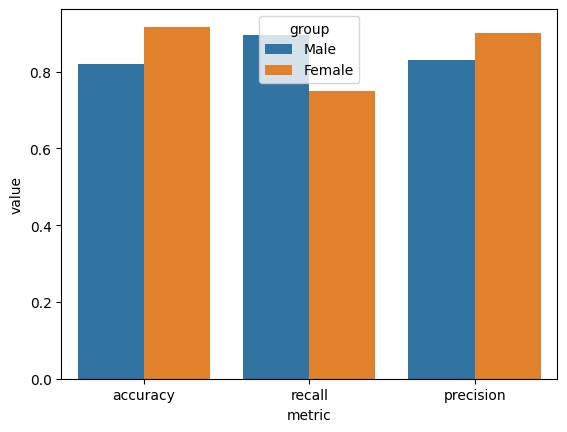

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from src.audit import evaluate_group, get_audit_dataset
import seaborn as sns
import pandas as pd

# Audit dataset
audit_dataset = get_audit_dataset(X_test, y_test, y_pred)

# Male subgroup evaluation
male_perf = evaluate_group(audit_dataset, "sex", 1)
male_perf['group'] = 'Male'

# Female subgroup evaluation
female_perf = evaluate_group(audit_dataset, "sex", 0)
female_perf['group'] = 'Female'

# Stratified performance dataframe
stratified_perf = pd.DataFrame([female_perf,male_perf])\
  [['accuracy','recall','precision','group']]\
  .melt(id_vars='group',var_name='metric',value_name='value')

# Plot perf metrics
sns.barplot(data=stratified_perf, x='metric', y='value',
            hue='group', hue_order=['Male','Female'])

# Stratified confusion matrix
audit_dataset['sex_label'] = audit_dataset['sex'].map({0:'Female',1:'Male'})
audit_dataset['prediction_label'] = audit_dataset['prediction']\
  .map({0:"Pred: Healthy", 1:"Pred: Heart Disease"})
audit_dataset['ground_truth_label'] = audit_dataset['ground_truth']\
  .map({0:"Actual: Healthy", 1:"Actual: Heart Disease"})

stratified_confusion_table = pd.crosstab(
    index = [audit_dataset['sex_label'], audit_dataset['prediction_label']],
    columns = audit_dataset['ground_truth_label'],
    margins=True,
    margins_name="Total"
)

print(stratified_confusion_table)


## Causal bias analysis and mitigation

In [29]:
pip install -q semopy

Assuming the following causal model describes the dataset:
$$ y_{pred} = \beta_{0} + \beta_1y_{true} + \beta_2a + \epsilon $$

where $a$ is the sensitive attribute (i.e. sex)

We estimate $\beta_0$, $\beta_1$ and $\beta_2$:

In [36]:
import semopy

causal_features = pd.DataFrame()
causal_features['a'] = X_train['sex']
causal_features['y_true'] = y_train
causal_features['y_pred'] = pipeline.predict(X_train)

model_desc='''
  y_pred ~ y_true + a
'''

causal_model = semopy.ModelMeans(model_desc)
causal_model.fit(causal_features)
causal_params = causal_model.inspect()
print(causal_params)

#Retrieve the coefficients of the causal model
beta0 = causal_params[causal_params.rval == "1"]['Estimate'].values
beta1 = causal_params[causal_params.rval == "y_true"]['Estimate'].values
beta2 = causal_params[causal_params.rval == "a"]['Estimate'].values
beta2_signif = causal_params[causal_params.rval == "a"]['p-value'].values


     lval  op    rval  Estimate  Std. Err    z-value       p-value
0  y_pred   ~  y_true  0.592937  0.074627   7.945313  1.998401e-15
1  y_pred   ~       a  0.061508  0.090830   0.677179  4.982924e-01
2  y_pred   ~       1  0.252913  0.079207   3.193057  1.407753e-03
3  y_pred  ~~  y_pred  0.860892  0.046349  18.574176  0.000000e+00


By setting the coefficient of $a$ to zero, i.e. by removing the bias in the model, we get the corrected prediction $y_{correct}$

$$ y_{correct} = \beta_{0} + \beta_1y_{true} + \epsilon $$

and therefore:

$$ y_{correct} = y_{pred} - \frac{\beta_2}{\beta1}a $$

In [37]:
if (beta2_signif < 0.05):
  y_correct = y_pred
else:
  pass
  # Retrieve classification threshold from the black box model
  # threshold = pipeline.named_steps['classifier'].???

  # Calculate y_correct from y_pred_probs
  # Apply threshold for the classification
  # Compare perf overall and across stratas